# Загрузка данных

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("starsw/intersection-flow-5k")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/intersection-flow-5k


In [158]:
import os
import xml.etree.ElementTree as ET
from PIL import Image

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.ops import box_convert

from transformers import DetrImageProcessor, DetrForObjectDetection, DetrConfig
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.ops import box_iou

from tqdm import tqdm

from torch.optim import AdamW

import matplotlib.pyplot as plt
import matplotlib.patches as patches

## Датасет класс

In [7]:
class IntersectionFlowDataset(Dataset):
    def __init__(self, images_dir, labels_dir, image_processor):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.image_processor = image_processor

        self.image_files = sorted([
            f for f in os.listdir(images_dir)
            if f.endswith((".jpg", ".png", ".jpeg"))
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_name)
        label_path = os.path.join(
            self.labels_dir,
            os.path.splitext(image_name)[0] + ".txt"
        )

        image = Image.open(image_path).convert("RGB")
        w, h = image.size

        coco_annotations = []

        if os.path.exists(label_path):
            with open(label_path) as f:
                for line in f:
                    cls, cx, cy, bw, bh = map(float, line.split())

                    x = (cx - bw / 2) * w
                    y = (cy - bh / 2) * h
                    bw_px = bw * w
                    bh_px = bh * h

                    coco_annotations.append({
                        "bbox": [x, y, bw_px, bh_px],
                        "category_id": int(cls),
                        "area": bw_px * bh_px,
                        "iscrowd": 0
                    })

        target = {
            "image_id": idx,
            "annotations": coco_annotations
        }

        encoding = self.image_processor(
            images=image,
            annotations=target,
            return_tensors="pt"
        )

        return {
            "pixel_values": encoding["pixel_values"].squeeze(0),
            "labels": encoding["labels"][0]
        }


In [8]:
class2id = {
    "vehicle": 0,
    "bus": 1,
    "bicycle": 2,
    'pedestrian': 3,
    'engine': 4,
    'truck': 5,
    'tricycle': 6,
    'obstacle': 7,
}

In [9]:
def collate_fn(batch):
    pixel_values = torch.stack([b["pixel_values"] for b in batch])
    labels = [b["labels"] for b in batch]
    return {
        "pixel_values": pixel_values,
        "labels": labels
    }


In [10]:
train_dataset = IntersectionFlowDataset(
    images_dir="/kaggle/input/intersection-flow-5k/Intersection-Flow-5K/images/train",
    labels_dir="/kaggle/input/intersection-flow-5k/Intersection-Flow-5K/labels/train",
    image_processor=image_processor
)

train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

val_dataset = IntersectionFlowDataset(
    images_dir="/kaggle/input/intersection-flow-5k/Intersection-Flow-5K/images/val",
    labels_dir="/kaggle/input/intersection-flow-5k/Intersection-Flow-5K/labels/val",
    image_processor=image_processor
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)


# Проверка, что даталоадер работает

In [11]:
batch = next(iter(train_loader))

pixel_values = batch["pixel_values"] # [B, 3, H, W]
labels = batch["labels"] # list of dicts

# возьмём первый сэмпл в batch
img_tensor = pixel_values[0]
target = labels[0]


In [12]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

# mean/std из DetrImageProcessor
mean = torch.tensor(image_processor.image_mean).view(3, 1, 1)
std = torch.tensor(image_processor.image_std).view(3, 1, 1)

img = img_tensor.cpu() * std + mean
img = img.clamp(0, 1)

# CHW → HWC
img = img.permute(1, 2, 0).numpy()


In [13]:
h, w, _ = img.shape
boxes = target["boxes"].cpu().numpy()
class_ids = target["class_labels"].cpu().numpy()

xyxy = []

for cx, cy, bw, bh in boxes:
    x1 = (cx - bw / 2) * w
    y1 = (cy - bh / 2) * h
    x2 = (cx + bw / 2) * w
    y2 = (cy + bh / 2) * h
    xyxy.append([x1, y1, x2, y2])


In [16]:
# img = HWC float [0,1]
img_vis = (img * 255).astype(np.uint8)

# убедимся, что память непрерывная
img_vis = np.ascontiguousarray(img_vis)

for (x1, y1, x2, y2), cls in zip(xyxy, class_ids):
    cv2.rectangle(
        img_vis,
        (int(x1), int(y1)),
        (int(x2), int(y2)),
        (0, 255, 0),
        2
    )
    cv2.putText(
        img_vis,
        str(cls),
        (int(x1), int(y1) - 5),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (255, 0, 0),
        2
    )


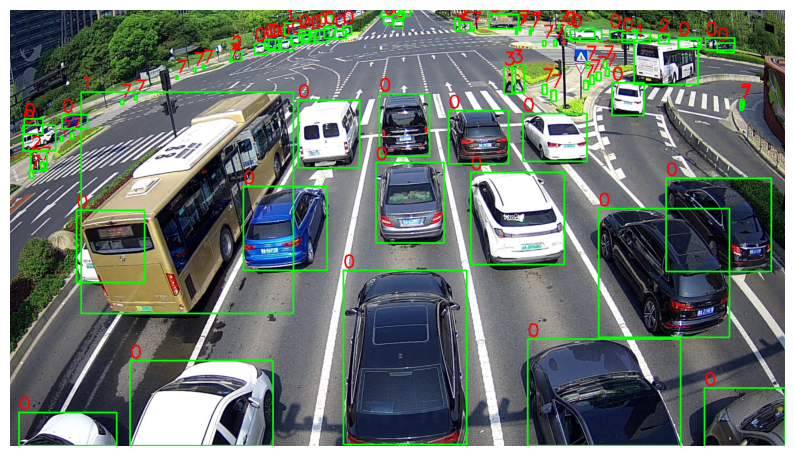

In [17]:
plt.figure(figsize=(10, 10))
plt.imshow(img_vis)
plt.axis("off")
plt.show()


# Загрузка модели

In [18]:
model_name = "facebook/detr-resnet-50"

image_processor = DetrImageProcessor.from_pretrained(model_name)
model = DetrForObjectDetection.from_pretrained(
    model_name,
    num_labels=len(class2id),
    id2label={v:k for k,v in class2id.items()},
    label2id=class2id,
    ignore_mismatched_sizes=True
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

print('model loaded')

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

model loaded


# Обучение

In [20]:
optimizer = AdamW(model.parameters(), lr=1e-5)


In [22]:
def compute_iou(box1, box2):
    """
    box: [x1, y1, x2, y2] в пикселях
    """
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_area = max(0, x2-x1) * max(0, y2-y1)
    box1_area = (box1[2]-box1[0]) * (box1[3]-box1[1])
    box2_area = (box2[2]-box2[0]) * (box2[3]-box2[1])
    union = box1_area + box2_area - inter_area

    if union == 0:
        return 0
    return inter_area / union


In [23]:
def compute_simple_map(pred_boxes, pred_labels, gt_boxes, gt_labels, iou_threshold=0.5):
    """
    Все координаты в пикселях
    pred_boxes: list of [x1,y1,x2,y2]
    pred_labels: list of class_id
    gt_boxes: list of [x1,y1,x2,y2]
    gt_labels: list of class_id
    """
    tp, fp, fn = 0, 0, 0
    matched = set()
    
    for pb, pl in zip(pred_boxes, pred_labels):
        found = False
        for i, (gb, gl) in enumerate(zip(gt_boxes, gt_labels)):
            if i in matched:
                continue
            if pl == gl and compute_iou(pb, gb) >= iou_threshold:
                tp += 1
                matched.add(i)
                found = True
                break
        if not found:
            fp += 1
    
    fn = len(gt_boxes) - len(matched)
    precision = tp / (tp + fp) if tp+fp>0 else 0
    recall = tp / (tp + fn) if tp+fn>0 else 0
    return precision, recall


In [28]:
best_map = 0.0
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for batch in loop:
        pixel_values = batch["pixel_values"].to(device)
        labels = [
            {k: v.to(device) for k,v in t.items()}
            for t in batch["labels"]
        ]

        outputs = model(
            pixel_values=pixel_values,
            labels=labels
        )

        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())

    # --- eval после эпохи ---
    model.eval()
    all_prec, all_rec = [], []
    
    with torch.no_grad():
        for batch in tqdm(val_loader):
            pixel_values = batch["pixel_values"].to(device)
            labels_batch = batch["labels"]
    
            outputs = model(pixel_values=pixel_values)
            sizes = [(pv.shape[1], pv.shape[2]) for pv in pixel_values]
    
            results_batch = image_processor.post_process_object_detection(
                outputs,
                target_sizes=sizes,
                threshold=0.5
            )
    
            for res, target in zip(results_batch, labels_batch):
                # GT boxes и labels (в пикселях)
                gt_boxes = target["boxes"].cpu().numpy()
                gt_labels = target["class_labels"].cpu().numpy()
    
                # предсказанные
                pred_boxes = res["boxes"].cpu().numpy()
                pred_labels = res["labels"].cpu().numpy()
    
                prec, rec = compute_simple_map(pred_boxes, pred_labels, gt_boxes, gt_labels)
                all_prec.append(prec)
                all_rec.append(rec)
    
    mean_prec = np.mean(all_prec)
    mean_rec = np.mean(all_rec)
    map_val = mean_prec  # упрощённый mAP как средняя точность
    print(f"Epoch {epoch+1} Precision: {mean_prec:.4f}, Recall: {mean_rec:.4f}")
    
    # сохраням модель, если улучшилась метрика
    if map_val > best_map:
        best_map = map_val
        model.save_pretrained(f"/kaggle/working/detr-best-epoch{epoch+1}")
        image_processor.save_pretrained(f"/kaggle/working/detr-best-epoch{epoch+1}")
        print(f"Saved new best model at epoch {epoch+1} with Precision {mean_prec:.4f}")

100%|██████████| 91/91 [01:06<00:00,  1.37it/s]


Epoch 1 Precision: 0.0000, Recall: 0.0000


100%|██████████| 91/91 [00:57<00:00,  1.59it/s]


Epoch 2 Precision: 0.0000, Recall: 0.0000


100%|██████████| 91/91 [01:07<00:00,  1.35it/s]


Epoch 3 Precision: 0.0000, Recall: 0.0000


100%|██████████| 91/91 [00:57<00:00,  1.59it/s]


Epoch 4 Precision: 0.0000, Recall: 0.0000


100%|██████████| 91/91 [00:57<00:00,  1.58it/s]

Epoch 5 Precision: 0.0000, Recall: 0.0000


In [29]:
model.save_pretrained(f"/kaggle/working/detr-best-epoch{epoch+1}_test")
image_processor.save_pretrained(f"/kaggle/working/detr-best-epoch{epoch+1}_test")

['/kaggle/working/detr-best-epoch5_test/preprocessor_config.json']

# Inference

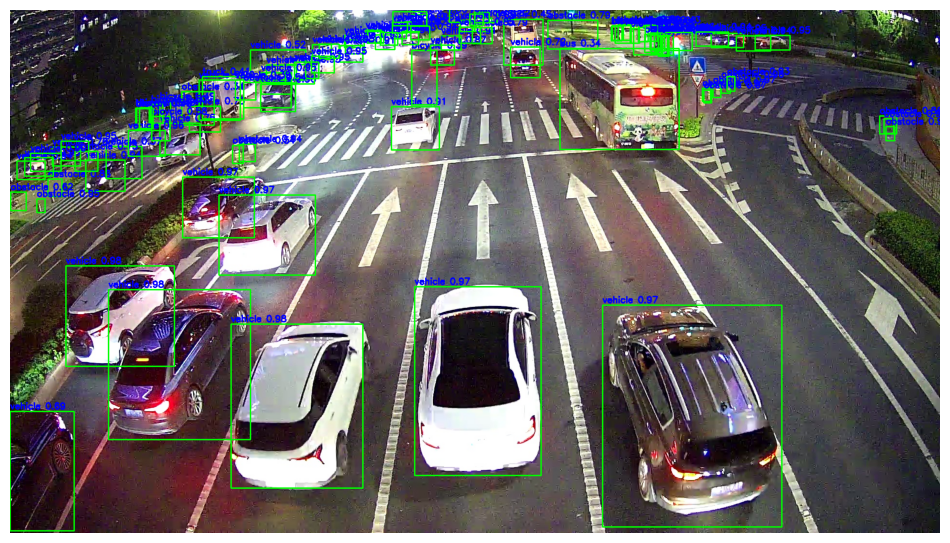

In [43]:
model.eval()
index_picture = 270

sample = val_dataset[index_picture]  # или любой индекс
pixel_values = sample["pixel_values"].unsqueeze(0).to(device)  # [1, 3, H, W]

with torch.no_grad():
    outputs = model(pixel_values=pixel_values)

# Получаем размеры исходного изображения
image = np.array(cv2.imread(
    "/kaggle/input/intersection-flow-5k/Intersection-Flow-5K/images/val/" + val_dataset.image_files[index_picture]
))
orig_h, orig_w = image.shape[:2]

# Post-process
target_sizes = torch.tensor([[orig_h, orig_w]])  # одно изображение
results = image_processor.post_process_object_detection(
    outputs, target_sizes=target_sizes, threshold=0.2
)[0]


boxes = results["boxes"].cpu().numpy()
labels = results["labels"].cpu().numpy()
scores = results["scores"].cpu().numpy()

id2label = {v: k for k, v in class2id.items()}

img_vis = image.copy()

for box, cls, score in zip(boxes, labels, scores):
    x1, y1, x2, y2 = box.astype(int)
    cv2.rectangle(img_vis, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(
        img_vis,
        f"{id2label[cls]} {score:.2f}",
        (x1, y1 - 5),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.6,
        (255, 0, 0),
        2
    )

# Отображение
plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()
